In [1]:
# standard packages for data analysis and NLP

import numpy as np
import pandas as pd
from copy import deepcopy

#visualization packages
import seaborn as sns
import matplotlib.pyplot as plt

# NLP modules we will use for text normalization
import re #regex 
import nltk # the natural language toolkit
from nltk.tokenize import word_tokenize
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk import pos_tag

# feature construction
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# import pyLDAvis.sklearn # a specialized package for topic model visualization

#modeling and dimensionality reduction for visuaization
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE

import time

# import data

In [2]:
df = pd.read_csv('processed_df\metacritic_comments_nlp.csv')
df.head()

,Title,Userscore,Comment,lang
0,The Legend of Zelda: Ocarina of Time,10.0,"Everything in OoT is so near at perfection, it...",en
1,The Legend of Zelda: Ocarina of Time,10.0,I won't bore you with what everyone is already...,en
2,The Legend of Zelda: Ocarina of Time,10.0,Anyone who gives the masterpiece below a 7 or ...,en
3,The Legend of Zelda: Ocarina of Time,10.0,I'm one of those people who think that this is...,en
4,The Legend of Zelda: Ocarina of Time,10.0,This game is the highest rated game on Metacr...,en


In [3]:
df.shape

(249031, 4)

# plots

- userscore distribution

In [54]:
df.Userscore.value_counts(normalize=True).sort_index()

1.0     0.028045
2.0     0.023399
3.0     0.027784
4.0     0.030896
5.0     0.039320
6.0     0.046508
7.0     0.065305
8.0     0.114773
9.0     0.205079
10.0    0.418892
Name: Userscore, dtype: float64

c:\Users\qwswe\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


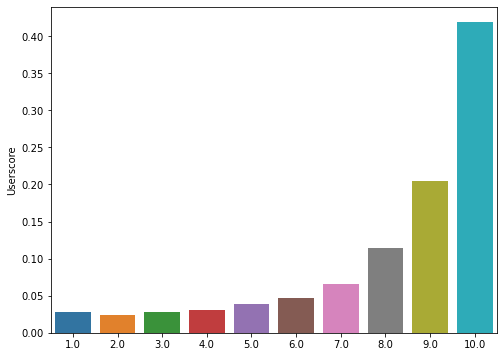

In [55]:
snsdf = df.Userscore.value_counts(normalize=True).sort_index()
snsdf = pd.DataFrame(snsdf)
snsdf

plt.figure(figsize=(8,6))
sns.barplot(snsdf.index, snsdf.Userscore);

# 41% user gave a 10.0

- length of comments

In [56]:
df['Comment_len'] = df['Comment'].map(lambda x: len(x))

<AxesSubplot:xlabel='Userscore', ylabel='Comment_len'>

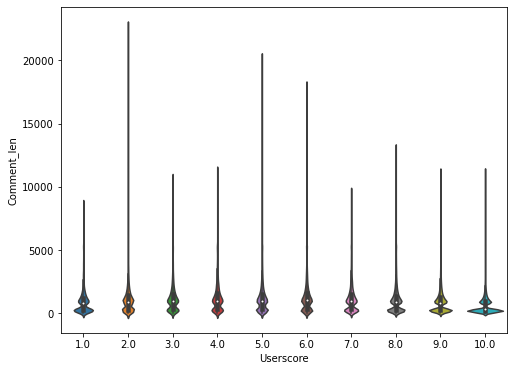

In [57]:
plt.figure(figsize=(8,6))
sns.violinplot(y=df['Comment_len'], x=df['Userscore'])

<AxesSubplot:xlabel='Userscore', ylabel='Comment_len'>

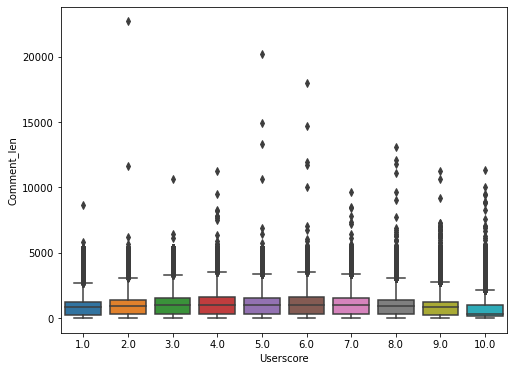

In [58]:
plt.figure(figsize=(8,6))
sns.boxplot(y=df['Comment_len'], x=df['Userscore'])

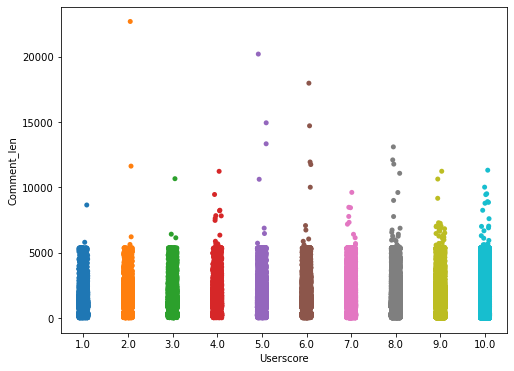

In [59]:
plt.figure(figsize=(8,6))
sns.stripplot(y=df['Comment_len'], x=df['Userscore']);

- popular game title

In [60]:
df['Title'].value_counts()

Call of Duty: Modern Warfare 3    3571
The Elder Scrolls V: Skyrim       3439
Diablo III                        3270
Mass Effect 3                     2944
Fallout 4                         2825
                                  ... 
Quell Memento                        1
Frozen Synapse Prime                 1
Super One More Jump                  1
escapeVektor: Chapter 1              1
Test Drive V-Rally                   1
Name: Title, Length: 2323, dtype: int64

<AxesSubplot:ylabel='Frequency'>

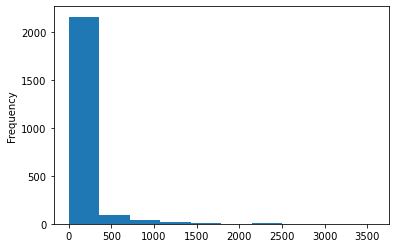

In [61]:
df.groupby('Title').size().plot(kind='hist', bins=10)

# preprocessing

* Capitalization
* Special pattern
* Numbers

In [4]:
# additional argument sets cut off minimum length for tokenized text at which function converts to null string.
def process_text(text, min_length):

    # drop non-english words
    words = set(nltk.corpus.words.words())
    # " ".join(w for w in nltk.wordpunct_tokenize(text) if w.lower() in words or not w.isalpha())

    # get common stop words that we'll remove during tokenization/text normalization
    stop_words = stopwords.words('english')

    #initialize lemmatizer
    wnl = WordNetLemmatizer()

    # helper function to change nltk's part of speech tagging to a wordnet format.
    def pos_tagger(nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:         
            return None
   

    # lower case everything
    text_lower = text.lower()
    
    # remove stop words and punctuations 
    text_norm = [x for x in word_tokenize(text_lower) if ((x.isalpha()) & (x not in stop_words))]

    #  POS detection on the result will be important in telling Wordnet's lemmatizer how to lemmatize
    
    # creates list of tuples with tokens and POS tags in wordnet format
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(text_norm))) 

    # cutoff for tokenized length
    if len(wordnet_tagged) <= min_length:
        return ''
    else:
         # rejoins lemmatized sentence 
         text_norm = " ".join([wnl.lemmatize(x[0], x[1]) for x in wordnet_tagged if x[1] is not None])
         return text_norm

In [5]:
df.shape

(249031, 4)

In [6]:
df['Userscore'].value_counts(normalize=True)

10.0    0.418892
9.0     0.205079
8.0     0.114773
7.0     0.065305
6.0     0.046508
5.0     0.039320
4.0     0.030896
1.0     0.028045
3.0     0.027784
2.0     0.023399
Name: Userscore, dtype: float64

In [17]:
def subset_and_process(p, df, colname):
    sample_size = int(df.shape[0]*p)  # 1% of origin
    print(f'subset size: {sample_size}')
    print(f'full dataset size: {df.shape[0]}')
    print(f'{p*100}%')

    df_sub = df.sample(sample_size,random_state=2333) 
    df_sub['Userscore'].value_counts(normalize=True)

    start = time.time()
    df_sub['Comment'] = df_sub['Comment'].apply(process_text, min_length = 10)
    end = time.time()
    print(f'{end-start} seconds slipped.')

    return df_sub

In [18]:
df_sub_1 = subset_and_process(0.001,df,'Comment')

subset size: 249
full dataset size: 249031
0.1%
17.666672468185425 seconds slipped.


In [ ]:
df_sub_30 = subset_and_process(0.3,df,'Comment')

In [73]:
sample_size = int(df.shape[0]*0.01)  # 1% of origin
print(f'sample size {sample_size}')

df_sub = df.sample(sample_size,random_state=2333) 

sample size 2490


10.0    0.423695
9.0     0.195984
8.0     0.115663
7.0     0.058233
6.0     0.055422
5.0     0.038554
4.0     0.032129
3.0     0.028916
1.0     0.028112
2.0     0.023293
Name: Userscore, dtype: float64

In [74]:
start = time.time()
df_sub['Comment'] = df_sub['Comment'].apply(process_text, min_length = 10)
end = time.time()
print(f'{end-start} seconds slipped.')

253.0366735458374 seconds slipped.


In [100]:
sample_size = int(df.shape[0]*0.05)  # 5% of origin
print(f'sample size {sample_size}')

df_sub = df.sample(sample_size,random_state=2333) 

start = time.time()
df_sub['Comment'] = df_sub['Comment'].apply(process_text, min_length = 10)
end = time.time()
print(f'{end-start} seconds slipped.')

sample size 12451
1264.700969696045 seconds slipped.


In [19]:
# 10x roughly take 2530s = 42m to run
sample_size = int(df.shape[0]*0.1)  # 10% of origin
print(f'sample size {sample_size}')

df_sub_10 = df.sample(sample_size,random_state=2333) 
df_sub_10['Userscore'].value_counts(normalize=True)

10.0    0.442044
9.0     0.198779
8.0     0.109225
7.0     0.066410
6.0     0.042752
5.0     0.039280
1.0     0.027515
4.0     0.026230
3.0     0.025265
2.0     0.022501
Name: Userscore, dtype: float64

In [20]:
start = time.time()
df_sub_10['Comment'] = df_sub_10['Comment'].apply(process_text, min_length = 10)
end = time.time()
print(f'{end-start} seconds slipped.')

1547.081153869629 seconds slipped.


In [96]:
# process full dataset
# by estimate, it would take 7 hours

start = time.time()
df['Comment'] = df['Comment'].apply(process_text, min_length = 10)
end = time.time()
print(f'{end-start} seconds slipped.')

KeyboardInterrupt: 

**pickle**

In [120]:
df_sub.to_pickle('processed_df/preprocessed_nlp_5p.pkl')
# proprocessed texts, 155554, non-english, no userscore 0.0

# df = pickle.load(open('processed_df/preprocessed_nlp','rb'))

In [118]:
import pickle

In [121]:
dfff = pickle.load(open('processed_df/preprocessed_nlp_5p.pkl','rb'))

In [122]:
dfff

,Title,Userscore,Comment,lang,Comment_len
211190,Star Wars: Battlefront II,2.0,there nothing quite gun entire platoon clone d...,en,320
39249,The Witcher 3: Wild Hunt,10.0,game absolutely gorgeous run steady gtx hairwo...,en,795
204931,This War of Mine,10.0,really good game didnt expect first survival g...,en,296
75752,Golden Sun,10.0,people eagerly anticipate initial release game...,en,783
199503,Assassin's Creed IV: Black Flag,8.0,best assassin creed far open world fresh missi...,en,177
...,...,...,...,...,...
238910,Assassin's Creed,10.0,reveal secret game yet secret buy game know ga...,en,1205
37826,Metal Gear Solid 4: Guns of the Patriots,10.0,probably big blow mg sage masterpiece bible th...,en,874
70202,Crysis,10.0,awesome experience great start trilogy start k...,en,325
171148,Call of Duty: World at War,9.0,game deserve lot credit gotten aside first mis...,en,1292


# count vectorization

In [47]:
ctvectorizer = CountVectorizer(min_df = 0.05, max_df = 0.8)
ctdf = ctvectorizer.fit_transform(corpus)

In [48]:
bow_mat = pd.DataFrame(ctdf.toarray(), columns = ctvectorizer.get_feature_names_out())
bow_mat['Userscore'] = df['Userscore']

AttributeError: 'CountVectorizer' object has no attribute 'get_feature_names_out'

In [49]:
high_bow_mat = bow_mat[bow_mat['Userscore'] == 10.0].drop(columns = ['Userscore'])

N_tok = high_bow_mat.sum(axis=0)
N = high_bow_mat.values.sum()

proba_c = N_tok/N

proba_c.sort_values(ascending=False)[0:20]

NameError: name 'bow_mat' is not defined

In [50]:
low_bow_mat = bow_mat[bow_mat['Userscore'] <2.0].drop(columns = ['Userscore'])

N_tok = low_bow_mat.sum(axis=0)
N = low_bow_mat.values.sum()

proba_c = N_tok/N

proba_c.sort_values(ascending=False)[0:20]

NameError: name 'bow_mat' is not defined

# TFIDF

In [102]:
# after proprocess, there will be empty comment
# due to min_length

df_new = df_sub[df_sub['Comment'] != '']

In [103]:
corpus = df_new['Comment']
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(corpus)
X_train

<11775x27981 sparse matrix of type '<class 'numpy.float64'>'
	with 572166 stored elements in Compressed Sparse Row format>

In [104]:
X_train.shape

(11775, 27981)

In [105]:
feature_names = vectorizer.get_feature_names() #get tfidf vector for first document 
first_document_vector = X_train[0]  #print the scores 
df_temp = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"]) 
df_temp.sort_values(by=["tfidf"],ascending=False).head(15)

,tfidf
squanders,0.306788
droids,0.293939
platoon,0.277750
reinforcement,0.271972
imperial,0.255784
rebel,0.252763
side,0.243020
troop,0.224307
victory,0.217001
there,0.202340


# Topic Modeling

In [106]:
topic_model = NMF(n_components = 7)
topic_model.fit(X_train)

NMF(n_components=7)

In [107]:
# to get H
H = topic_model.transform(X_train) # transform document into topic vector representation

# to get W 
W = topic_model.components_ # word component weights for each topic

print("Shape of W is " + str(W.shape))
print("Shape of H is " + str(H.shape))
print("Shape of X_train is " + str(X_train.shape))

Shape of W is (7, 27981)
Shape of H is (11775, 7)
Shape of X_train is (11775, 27981)


In [108]:
for index,topic in enumerate(W):
    print(f'THE TOP 10 WORDS FOR TOPIC #{index}')
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-25:]])
    print('\n')

THE TOP 10 WORDS FOR TOPIC #0
['enjoy', 'make', 'amazing', 'much', 'even', 'many', 'know', 'really', 'think', 'never', 'go', 'want', 'say', 'people', 'give', 'hour', 'first', 'year', 'buy', 'time', 'love', 'get', 'fun', 'play', 'game']


THE TOP 10 WORDS FOR TOPIC #1
['see', 'easily', 'probably', 'time', 'world', 'beautiful', 'wii', 'mario', 'awesome', 'masterpiece', 'series', 'perfect', 'uncharted', 'story', 'gameplay', 'amaze', 'year', 'rpg', 'graphic', 'far', 'make', 'play', 'game', 'ever', 'best']


THE TOP 10 WORDS FOR TOPIC #2
['overall', 'storyline', 'incredible', 'atmosphere', 'love', 'visuals', 'excellent', 'beautiful', 'well', 'perfect', 'soundtrack', 'puzzle', 'music', 'sound', 'fantastic', 'fun', 'character', 'amazing', 'amaze', 'awesome', 'game', 'gameplay', 'story', 'graphic', 'great']


THE TOP 10 WORDS FOR TOPIC #3
['series', 'weapon', 'gun', 'modern', 'black', 'warfare', 'well', 'zombie', 'ops', 'online', 'shooter', 'fps', 'battlefield', 'map', 'call', 'new', 'duty', '

In [109]:
%%capture topic_word_plot
def plot_top_words(W, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 7, figsize=(15, 8), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(W):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 20})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=15)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=25)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

n_top_words = 20
tfidf_feature_names = vectorizer.get_feature_names()
plot_top_words(W, tfidf_feature_names, n_top_words, "Topics in NMF model")

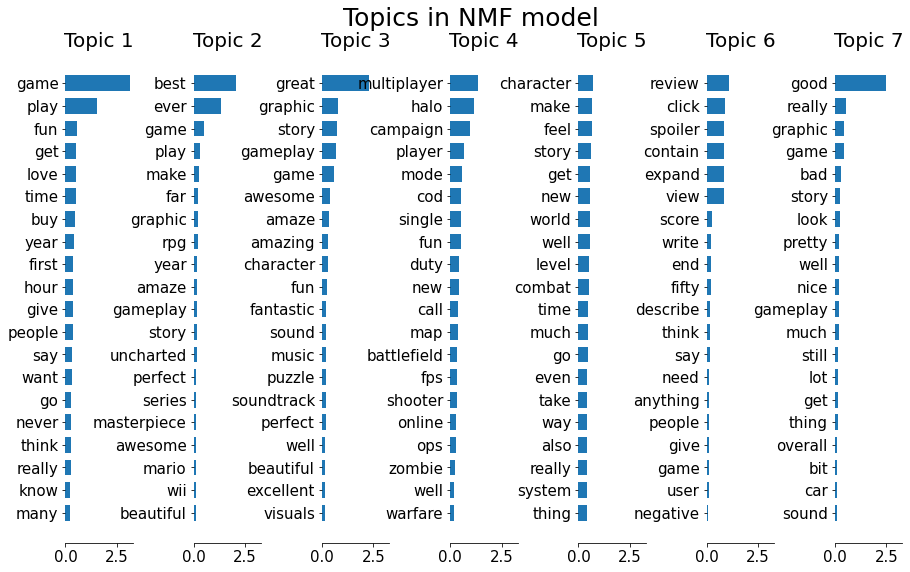

In [111]:
topic_word_plot()

In [112]:
topic_name_dict = {0: 'general good game', 1: 'wii dog rpg masterpiece', 2: 'amazing story and audio',
                   3: 'multiplayer shooter', 4: 'combat world', 5:'console', 6:'game that make you wait long'}

# TSNE

In [113]:
tsne = TSNE(random_state=42, learning_rate=100)
tsne_trans = tsne.fit_transform(H)
tsne_trans = pd.DataFrame(tsne_trans, columns = ['TSNE1', 'TSNE2'])

In [114]:
tsne_trans['class'] = np.argmax(H, axis = 1)
tsne_trans['class'] = tsne_trans['class'].replace(topic_name_dict)

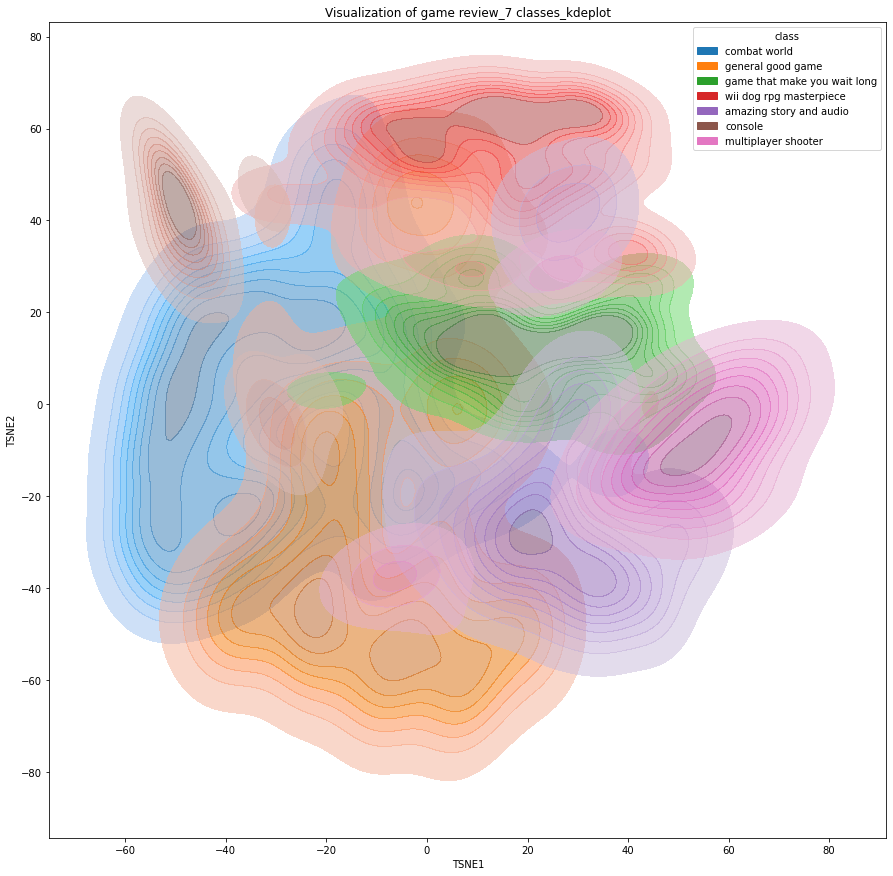

In [115]:
plt.figure(figsize=(15,15))
sns.kdeplot(x = 'TSNE1', y = 'TSNE2', hue = 'class', data = tsne_trans, palette = 'tab10', fill=True, alpha=.5)
plt.title('Visualization of game review_7 classes_kdeplot')
plt.show()